# Coalescence

Droplet coalescence happens throughout the condensation process. Each of such event reduce the total number of droplets by 1, while significantly increase the size of the droplet. The motivation of this analysis is to see how much coalescence affects the condensation flux calculation. 

## 0 Packages

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import os
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks
from myimagelib.myImageLib import readdata
from scipy.spatial import distance
import trackpy as tp

## 1 Track droplets

Droplets are detected in different frames. Now, we are linking droplets across different frames. In the first try, we use nearest-neighbor search to link droplet trajectories.

### 1.1 Nearest neighbor

In [3]:
def track_droplets(droplets, max_distance=10):
    """
    Track droplets across frames using nearest-neighbor search.
    
    Parameters:
    - droplets: List of DataFrames, each containing x, y, r for one frame.
    - max_distance: Maximum distance to consider droplets as the same.
    
    Returns:
    - tracks: List of lists, each containing (frame, x, y, r) for one droplet.
    """
    tracks = []
    for frame_idx, frame in enumerate(droplets):
        if frame_idx == 0:
            # Initialize tracks with the first frame
            for _, row in frame.iterrows():
                tracks.append([(frame_idx, row['x'], row['y'], row['r'])])
        else:
            # Track droplets in subsequent frames
            prev_frame = droplets[frame_idx - 1]
            for _, row in frame.iterrows():
                x, y, r = row['x'], row['y'], row['r']
                distances = distance.cdist(prev_frame[['x', 'y']], [[x, y]])
                min_dist_idx = np.argmin(distances)
                if distances[min_dist_idx] < max_distance:
                    tracks[min_dist_idx].append((frame_idx, x, y, r))
                else:
                    tracks.append([(frame_idx, x, y, r)])
    return tracks

In [21]:
# read data
folder = r"E:\F\06282024\tracking\exp5\blob"
l = readdata(folder, "csv")
droplets = [pd.read_csv(i.Dir) for num, i in l.iterrows()]
tracks = track_droplets(droplets)

### 1.2 `trackpy`

## 2 Detect coalescence

In [8]:
def detect_coalescence(tracks, radius_increase_threshold=1.5):
    """
    Detect coalescence events based on radius increase.
    
    Parameters:
    - tracks: List of lists, each containing (frame, x, y, r) for one droplet.
    - radius_increase_threshold: Factor by which the radius must increase to consider coalescence.
    
    Returns:
    - coalescence_events: List of tuples (frame, x, y, r, involved_droplets).
    """
    coalescence_events = []
    for track in tracks:
        for i in range(1, len(track)):
            prev_frame, prev_x, prev_y, prev_r = track[i - 1]
            curr_frame, curr_x, curr_y, curr_r = track[i]
            if curr_r > prev_r * radius_increase_threshold:
                coalescence_events.append((curr_frame, curr_x, curr_y, curr_r, track[:i]))
    return coalescence_events

In [22]:
# Detect coalescence events
coalescence_events = detect_coalescence(tracks)

In [30]:
df = pd.DataFrame(coalescence_events, columns=['frame', 'x', 'y', 'r', 'involved_droplets'])

(-0.5, 4606.5, 3070.5, -0.5)

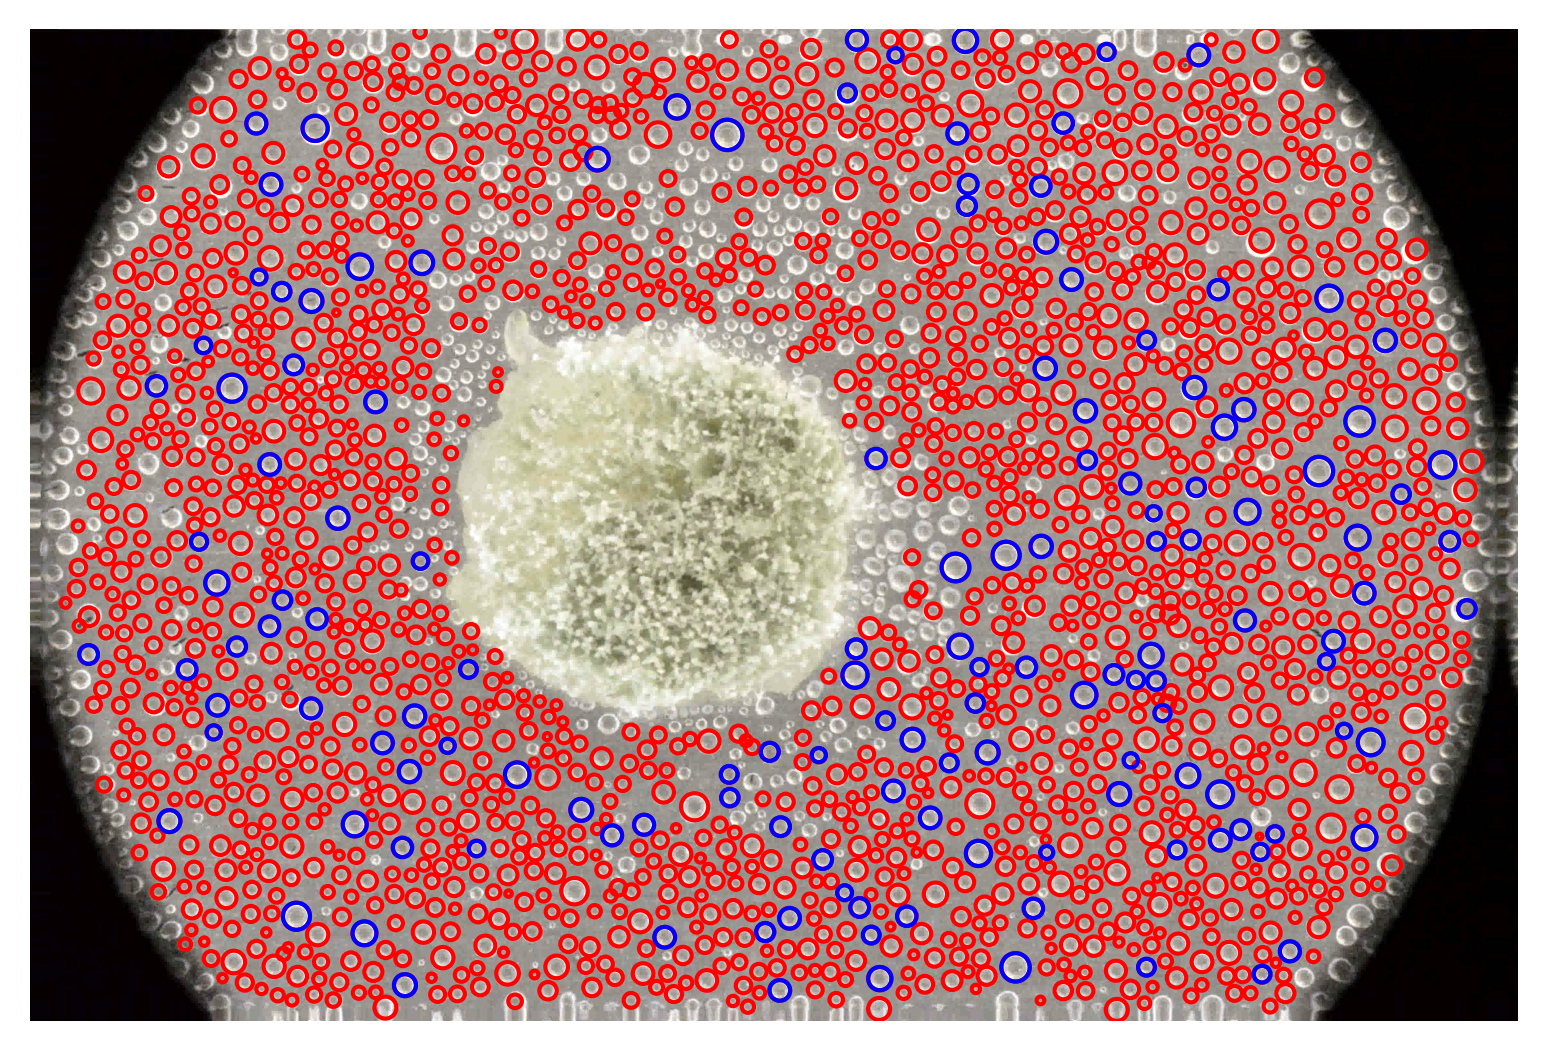

In [34]:
# show coalescence events in frame 0
folder = r"E:\F\06282024\tracking\exp5\blob"
frame_idx = 80
img = io.imread(os.path.join(folder, f"{frame_idx+25:04d}.jpg"))
fig, ax = plt.subplots(dpi=300)
ax.imshow(img, cmap='gray')
for _, x, y, r in droplets[frame_idx].itertuples():
    ax.add_artist(plt.Circle((x, y), r, color='r', fill=False))
for num, i in df.loc[df["frame"]==frame_idx].iterrows():
    ax.add_artist(plt.Circle((i.x, i.y), i.r, color='b', fill=False))
ax.axis('off')

In [33]:
df.loc[df["frame"]==frame_idx]

,frame,x,y,r,involved_droplets
56,80,2289.749756,2237.089355,28.0,"[(0, 4511.89013671875, 1633.6759033203125, 18...."
73,80,4448.451172,1794.369141,27.0,"[(0, 117.07717895507812, 913.79248046875, 17.0..."
108,80,1160.434814,2959.565918,34.0,"[(0, 4529.578125, 1602.135986328125, 15.0), (3..."
114,80,2630.654297,2939.261230,36.0,"[(0, 18.710664749145508, 1583.5955810546875, 2..."
312,80,431.184814,2451.600098,34.0,"[(0, 80.08370971679688, 1305.6983642578125, 20..."
...,...,...,...,...,...
7206,80,4244.675781,1439.360718,27.0,"[(0, 1411.9674072265625, 2176.703857421875, 18..."
7307,80,3129.132812,485.515625,30.0,"[(0, 3624.501953125, 2159.94970703125, 21.0), ..."
7326,80,2870.875732,322.691925,31.0,"[(0, 1211.61279296875, 2161.203125, 20.0), (1,..."
7331,80,2002.873047,240.560028,36.0,"[(0, 3575.174072265625, 2158.7470703125, 18.0)..."


In [1]:
1000 / 405.5308

2.465903946136767